# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

# Model load

In [2]:
path_qing_cheng = '../model/qing_cheng'
path_vallen = '../model/vallen'

qing_cheng_model_name = 'Qing-Cheng'
vallen_model_name = 'Vallen'

In [3]:
def get_file_paths(path: str):
    file_paths = []

    for dir_path, _, file_names in os.walk(path):
        file_path = {}
        
        for file_name in file_names:
            
            if file_name.endswith('all_results.csv'):
                file_path['all_results'] = os.path.join(dir_path, file_name)
                
        if len(file_path) > 0:
            file_paths.append(file_path)

    return file_paths

In [4]:
paths_qing_cheng = get_file_paths(path_qing_cheng)
paths_vallen = get_file_paths(path_vallen)

In [5]:
def load_model_result(path_dict: dict):    
    all_results = pd.read_csv(path_dict['all_results'])
    
    return {
        'all_results': all_results,
    }

In [6]:
qing_cheng_models = [load_model_result(path) for path in paths_qing_cheng]
vallen_models = [load_model_result(path) for path in paths_vallen]

In [7]:
# Analysis

In [8]:
def process_scores (scores: list):
    transposed_scores = list(zip(*scores))
    
    return [np.mean(score) for score in transposed_scores]

In [9]:
def process_fold_results (df: pd.DataFrame, model_name):
    new_df = df.copy()
    
    fold_results_df = new_df['Fold Results (accuracy, precision, recall, f1)'].apply(lambda row: eval(row))
    
    new_df.drop('Fold Results (accuracy, precision, recall, f1)',  axis=1, inplace=True)
    
    results_means_df = fold_results_df.apply(process_scores)
    
    new_df['accuracy'] = results_means_df.apply(lambda row: row[0])
    new_df['precision'] = results_means_df.apply(lambda row: row[1])
    new_df['recall'] = results_means_df.apply(lambda row: row[2])
    new_df['f1'] = results_means_df.apply(lambda row: row[3])
                                          
    new_df['model'] = new_df.apply(lambda row: f"{model_name}({ row['num_units'] },{ row['batch_size'] },{ row['epochs'] },{ row['drop_out'] })", axis=1)
    
    return new_df

In [10]:
def process_model_results(model_dict: dict, model_name: str):    
    column_dict = {'Num Units': 'num_units', 'Batch Size': 'batch_size', 'Epochs': 'epochs', 'Dense Activation': 'dense_activation', 'drop': 'drop_out'}
    
    model_dict['all_results'] = model_dict['all_results'].rename(column_dict, axis=1)
    
    model_dict['all_results'] = process_fold_results(model_dict['all_results'], model_name)
    
    return

In [11]:
for model in qing_cheng_models:
    process_model_results(model, qing_cheng_model_name)
    
for model in vallen_models:
    process_model_results(model, vallen_model_name)

# Plot

In [12]:
def parse_best_model_to_bar_plot(dfs, index = 7):
    metrics = ['accuracy', 'precision', 'recall', 'f1']

    best_model = pd.DataFrame()

    for metric in metrics:
        best_result = dfs[index]['all_results'].sort_values(metric, ascending=False).head(1)[['accuracy', 'precision', 'recall', 'f1', 'model']]
        
        model = best_result['model'].iloc[0]
        
        best_result = best_result.drop(columns=['model'], axis=1).T.reset_index()
        
        best_result.columns = ["Metric", "Value"]
        
        best_result['Model'] = model
        
        best_result['Sort by'] = metric
        
        best_model = pd.concat([best_model, best_result]).reset_index(drop=True)
        
    return best_model

In [13]:
best_qing_cheng_model = parse_best_model_to_bar_plot(qing_cheng_models, 7)
best_vallen_model = parse_best_model_to_bar_plot(vallen_models, 7)

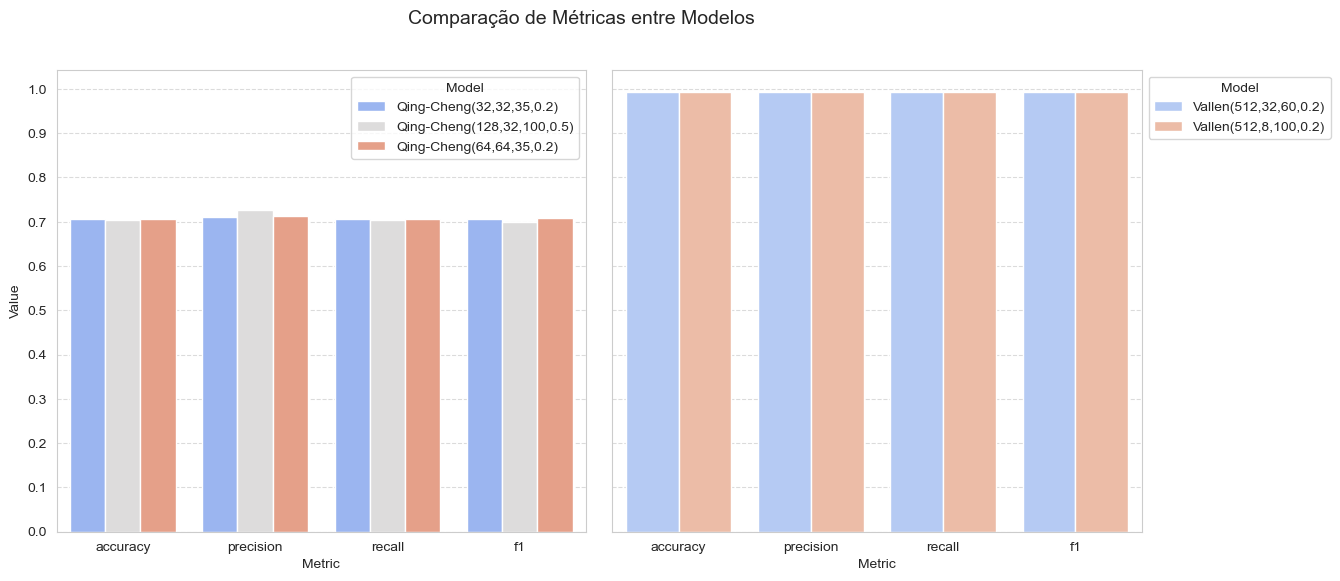

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True, gridspec_kw={'wspace': 0.05})

for i, best_model in enumerate([best_qing_cheng_model, best_vallen_model]):
    ax = axes[i]
    sns.barplot(x="Metric", y="Value", hue="Model", data=best_model, palette="coolwarm", ax=ax)

    ax.set_xlabel("Metric")
    ax.set_ylabel("Value")

    ax.legend(title="Model", bbox_to_anchor=(1, 1))
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    
plt.yticks(np.arange(0, 1.1, 0.1))
plt.suptitle("Comparação de Métricas entre Modelos", fontsize=14)
plt.show()